In [22]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
import sys
repo_dir = '/home/labs/amit/noamsh/repos/MM_2023'
sys.path.append(repo_dir)

In [4]:
from pathlib import Path

from omegaconf import OmegaConf
import anndata as ad
import scanpy as sc

In [5]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
config_path = Path(repo_dir, 'config.yaml')
conf = OmegaConf.load(config_path)

## data loading

In [6]:
# flo_rebalanced_CD45_adata_path = Path("/home/labs/amit/floriani/Lab/PROJECTS/Multiple Myeloma/MrVI_Assaf_Shuang/data/processed/2024-01-22_MrVI_CD45_latents.h5ad")
flo_rebalanced_CD45_adata_path = Path('/home/labs/amit/floriani/Lab/PROJECTS/Multiple Myeloma/MrVI_Assaf_Shuang/data/processed/2024-02-01_MrVI_MM_latents_CD45_combined.h5ad')
flo_rebalanced_CD45_adata = ad.read_h5ad(flo_rebalanced_CD45_adata_path)
flo_rebalanced_CD45_adata

AnnData object with n_obs × n_vars = 353539 × 5000
    obs: 'Amp.Batch.ID', 'Seq.Batch.ID', 'Batch.Set.ID', 'Member', 'Description', 'Included', 'Tissue', 'Gating', 'Total.PC', 'Total.NonPC', 'Initial.Code', 'Disease', 'Time_x', 'Project', 'Cohort', 'Weizmann.Code', 'Hospital.Code', 'Clinical.Data', 'batch', '_indices', '_scvi_sample', '_scvi_batch', '_scvi_labels', 'leiden_u', 'dummy_var', 'cell_indices', 'Code.Time', 'Code', 'Time_y', 'Disease Stage (MGUS=0, SMM=1, NDMM=2, RRMM=3)', 'Triple Ref.', 'Triple Exp.', 'Penta Ref.', 'Belantamab Exp.', 'IMiD Resistance (Len/Pom/Thali)', 'PI Resistance (Bort/Carf/Ixa)'
    var: 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches'
    uns: 'Gating_colors', 'Hospital.Code_colors', '_scvi_manager_uuid', '_scvi_uuid', 'batch_colors', 'hvg', 'leiden', 'leiden_u_colors', 'log1p', 'mrvi_u', 'mrvi_z', 'rank_genes_groups', 'umap'
    obsm: 'X_mrvi_u', 'X_mrvi_z', 'X_umap', 'X_umap_mrvi_u', 'X_um

In [7]:
# print(list(flo_rebalanced_CD45_adata.var_names))

## Build new neighborhood graph

In [8]:
rep_name = 'X_mrvi_u'
new_neigbros_key = 'new_mrvi_u'

In [9]:
sc.pp.neighbors(flo_rebalanced_CD45_adata, n_neighbors=50, use_rep=rep_name, key_added=new_neigbros_key)

In [10]:
sc.tl.umap(flo_rebalanced_CD45_adata, neighbors_key=new_neigbros_key)

/home/labs/amit/noamsh/.conda/envs/CLL_2024/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/labs/amit/noamsh/.conda/envs/CLL_2024/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


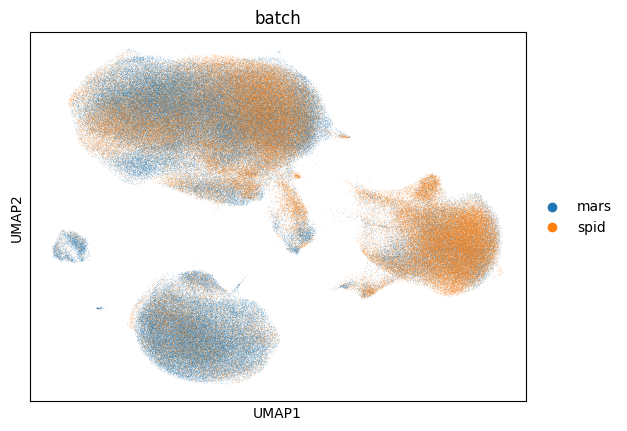

In [11]:
# flo_rebalanced_CD45_adata.obs["is_CD45"] = (flo_rebalanced_CD45_adata.obs["Gating"] == "CD45").astype('category')
sc.pl.umap(flo_rebalanced_CD45_adata, neighbors_key="new_neigbros_key", color=['batch'], ncols=2)

In [12]:
# sc.tl.leiden(flo_rebalanced_CD45_adata, neighbors_key=new_neigbros_key, resolution=0.5)

In [13]:
# sc.pl.umap(flo_rebalanced_CD45_adata, neighbors_key="new_neigbros_key", color=['leiden'],legend_loc="on data", ncols=2)

In [14]:
# sc.tl.embedding_density(flo_rebalanced_CD45_adata, groupby='Gating')
# sc.pl.embedding_density(flo_rebalanced_CD45_adata, groupby='Gating')

## merge labels - annotations

In [15]:
import pandas as pd
import pyreadr

In [16]:
spid_label_path = "/home/labs/amit/shuangyi/Project_MM_2023/ann_SPID_20231110_CD45.Rds"
mars_label_path = "/home/labs/amit/shuangyi/Project_MM_2023/ann_MARS_20231110_CD45.Rds"

mars_result = pyreadr.read_r(mars_label_path)
spid_result = pyreadr.read_r(spid_label_path)

df_mars_labels = mars_result[None] 
df_spid_labels = spid_result[None] 

In [17]:
label_col = "Populations"
# pd.concat([df_mars_labels[label_col].value_counts(normalize=True).rename("MARS_norm"),
#            df_mars_labels[label_col].value_counts().rename("MARS_count"),
#            df_spid_labels[label_col].value_counts(normalize=True).rename("SPID"),
#            df_spid_labels[label_col].value_counts().rename("SPID_count")], axis=1)

,MARS_norm,MARS_count,SPID,SPID_count
Populations,,,,
Mo,0.200080,14978.0,0.285479,30850.0
T_Naive,0.173377,12979.0,0.156509,16913.0
T_Effector,0.105811,7921.0,0.110351,11925.0
T_Effector_GZMB,0.102298,7658.0,0.108760,11753.0
B,0.094309,7060.0,0.034628,3742.0
Mo_CD16,0.071667,5365.0,0.046815,5059.0
NK,0.043147,3230.0,0.025392,2744.0
B_Pro,0.038913,2913.0,0.011947,1291.0
DC,0.035880,2686.0,0.083469,9020.0


In [18]:
all_labels = pd.concat([df_mars_labels[[label_col, "cID"]], df_spid_labels[[label_col, "cID"]]])
all_labels.head()

,Populations,cID
0,T_Naive,W811826
1,T_Naive,WMC3225438
2,T_Naive,WMC339832
3,T_Naive,WMC487931
4,T_Naive,WMC2789363


## annotation on embedding space

In [19]:
from data_loading.utils import merge_labels_to_adata

In [20]:
flo_rebalanced_CD45_adata = merge_labels_to_adata(flo_rebalanced_CD45_adata, all_labels, 
                        col_in_adata_to_merge_by="index", 
                        cols_in_labels_df_to_merge_by="cID", 
                        cols_to_validate_not_empty=[label_col], labels_col_names_to_merge=[label_col])

/home/labs/amit/noamsh/.conda/envs/CLL_2024/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/labs/amit/noamsh/.conda/envs/CLL_2024/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


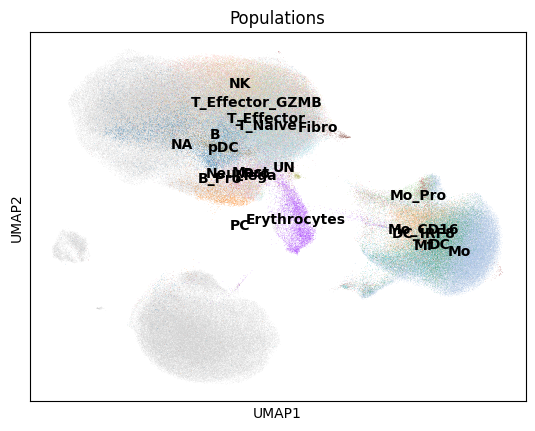

In [21]:
sc.pl.umap(flo_rebalanced_CD45_adata, neighbors_key="new_neigbros_key", color=[label_col],legend_loc="on data", ncols=2)

In [21]:
# adata = flo_rebalanced_CD45_adata[~ flo_rebalanced_CD45_adata.obs[[label_col]].isna().any(axis=1), :]
adata = flo_rebalanced_CD45_adata.copy()

## predict mars by spid annotations (and vice-versa)

#### data preperation

In [19]:

hyper_class_dict = {
    'B' :['B', 'B_Pro'],
    'T' : ['T_Effector', 'T_Effector_GZMB', 'T_Naive', 'NK'],
    'M_DC' : ['DC','DC_IRF8', 'Mf', 'Mo', 'Mo_CD16'],
}

class_2_hyper_class_map = {}
for h_c, c_list in hyper_class_dict.items():
    for c in c_list:
        class_2_hyper_class_map[c] = h_c

def _map_class_to_hyper_class(cls_name, mapper=class_2_hyper_class_map):
    return  mapper[cls_name] if cls_name in mapper else cls_name
    
# list(set(map(_map_class_to_cyper_class, mars_model.classes_)))

In [20]:
adata.obs["hyper_population"] = adata.obs[label_col].apply(_map_class_to_hyper_class)

In [21]:
mars_adata = adata[adata.obs['batch']=="mars"]
spid_adata = adata[adata.obs['batch']=="spid"]

In [22]:
mars_X = mars_adata.obsm['X_mrvi_u']
spid_X = spid_adata.obsm['X_mrvi_u']

In [23]:
mars_y = mars_adata.obs[label_col]
spid_y = spid_adata.obs[label_col]

In [24]:
from sklearn.neighbors import KNeighborsClassifier
from evaluation.visualizations import make_confusion_matrix

#### predict spid by mars

In [25]:
mars_model = KNeighborsClassifier(n_neighbors=21)
mars_model.fit(mars_X, mars_y)

KNeighborsClassifier(n_neighbors=21)

In [26]:
spid_y_pred = mars_model.predict(spid_X)

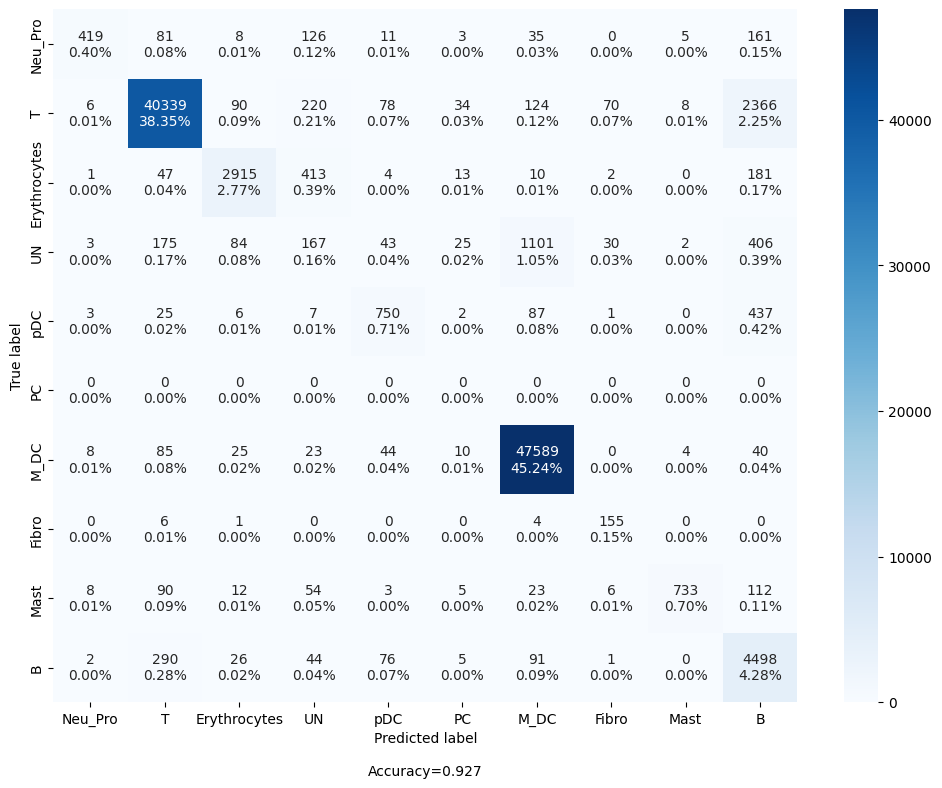

In [27]:
cats = list(set(map(_map_class_to_hyper_class, mars_model.classes_)))
cm = confusion_matrix(spid_y.apply(_map_class_to_hyper_class),
                      pd.Series(spid_y_pred).apply(_map_class_to_hyper_class),
                      labels=cats)
make_confusion_matrix(cm , categories=cats, figsize=(12, 9))

#### predict mars by spid

In [28]:
spid_model = KNeighborsClassifier(n_neighbors=21)
spid_model.fit(spid_X, spid_y)

KNeighborsClassifier(n_neighbors=21)

In [29]:
mars_y_pred = spid_model.predict(mars_X)

In [30]:
# predict origianl annotations (not hyper class anotations)

# cm = confusion_matrix(mars_y, mars_y_pred, labels=spid_model.classes_)
# make_confusion_matrix(cm , categories=spid_model.classes_, figsize=(16, 12))

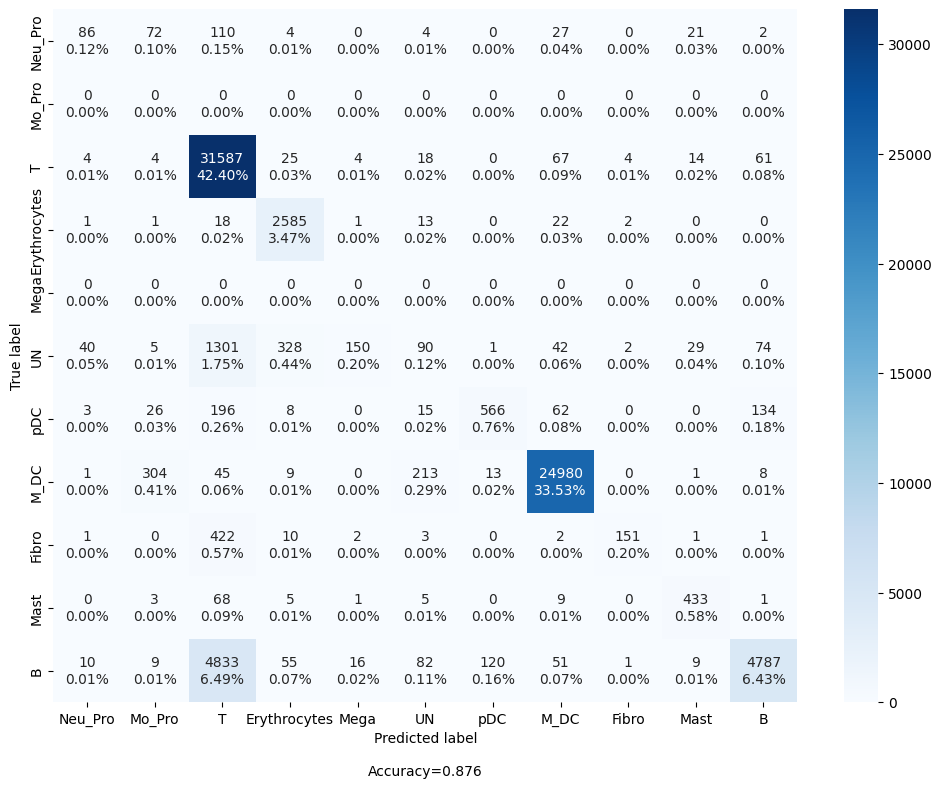

In [31]:
cats = list(set(map(_map_class_to_hyper_class, spid_model.classes_)))
cm = confusion_matrix(mars_y.apply(_map_class_to_hyper_class),
                      pd.Series(mars_y_pred).apply(_map_class_to_hyper_class),
                      labels=cats)
make_confusion_matrix(cm , categories=cats, figsize=(12, 9))

# error analysis - annotation

#### get mars B cells that are close to SPID T cells

In [32]:

labels_hyper_class = mars_y.apply(_map_class_to_hyper_class)
pred_hyper_class = pd.Series(mars_y_pred).apply(_map_class_to_hyper_class)
results_df = pd.DataFrame(index = labels_hyper_class.index, data={"label": labels_hyper_class.values, "pred": pred_hyper_class.values})
bad_cells_mars = results_df[(results_df["label"] == "B") & (results_df["pred"] == "T")].index


In [33]:

is_bad_mars = []
for i, row in adata.obs.iterrows():
    value = True if i in bad_cells_mars else False
    is_bad_mars.append(value)
adata.obs["bad_cells_mars"] = is_bad_mars
adata.obs["bad_cells_mars"] = adata.obs["bad_cells_mars"].astype('category')

#### get SPID T cells that are close to MARS B cells

In [34]:

labels_hyper_class = spid_y.apply(_map_class_to_hyper_class)
pred_hyper_class = pd.Series(spid_y_pred).apply(_map_class_to_hyper_class)
results_df = pd.DataFrame(index = labels_hyper_class.index, data={"label": labels_hyper_class.values, "pred": pred_hyper_class.values})
bad_cells_spid = results_df[(results_df["label"] == "T") & (results_df["pred"] == "B")].index


In [35]:

is_bad_spid = []
for i, row in adata.obs.iterrows():
    value = True if i in bad_cells_spid else False
    is_bad_spid.append(value)
adata.obs["bad_cells_spid"] = is_bad_spid
adata.obs["bad_cells_spid"] = adata.obs["bad_cells_spid"].astype('category')

#### visualize

/home/labs/amit/noamsh/.conda/envs/CLL_2024/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/labs/amit/noamsh/.conda/envs/CLL_2024/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/labs/amit/noamsh/.conda/envs/CLL_2024/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector

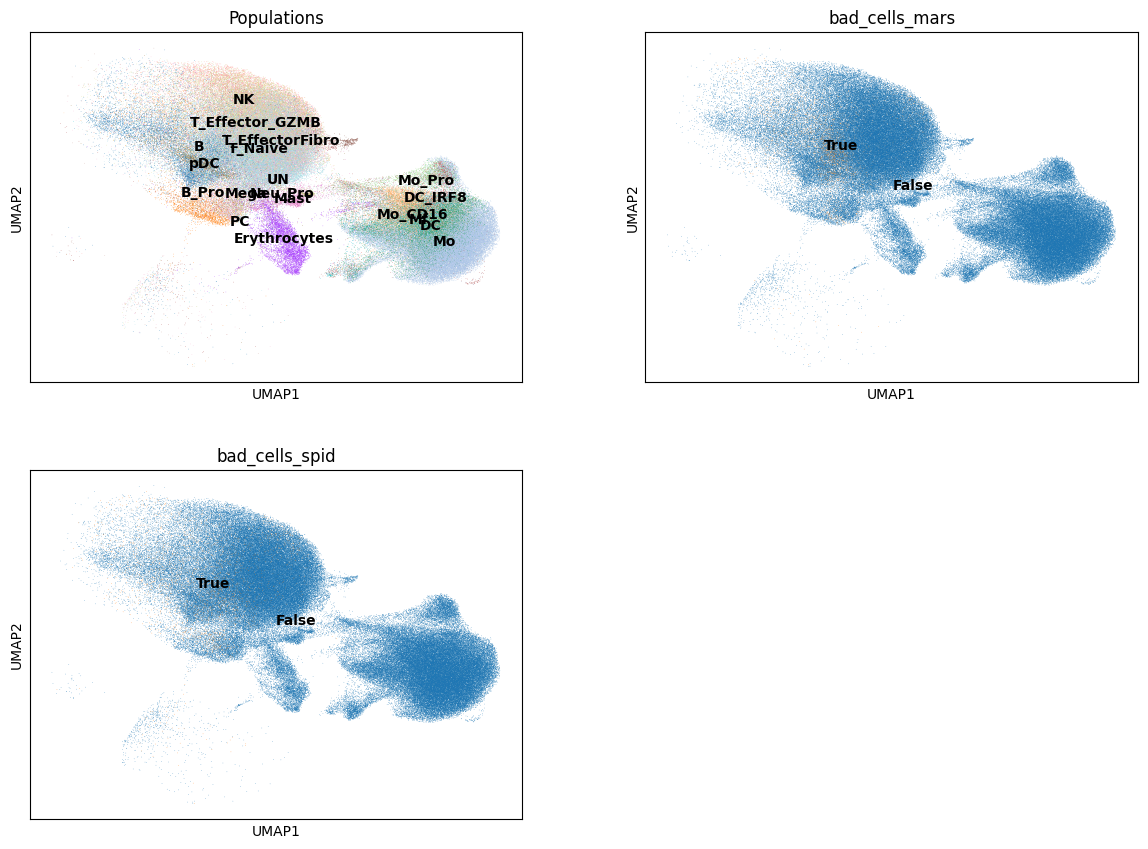

In [36]:
sc.pl.umap(adata, neighbors_key="new_neigbros_key", color=[label_col, "bad_cells_mars", 'bad_cells_spid'],legend_loc="on data", ncols=2)

### focus on B an T cell

In [37]:
adata_B_T = adata[(adata.obs["hyper_population"] == "B") | (adata.obs["hyper_population"] == "T")]
adata_B_T

View of AnnData object with n_obs × n_vars = 90129 × 5000
    obs: 'Amp.Batch.ID', 'Seq.Batch.ID', 'Batch.Set.ID', 'Member', 'Description', 'Included', 'Tissue', 'Gating', 'Total.PC', 'Total.NonPC', 'Initial.Code', 'Disease', 'Time_x', 'Project', 'Cohort', 'Weizmann.Code', 'Hospital.Code', 'Clinical.Data', 'batch', '_indices', '_scvi_sample', '_scvi_batch', '_scvi_labels', 'leiden_u', 'dummy_var', 'cell_indices', 'Code.Time', 'Code', 'Time_y', 'Disease Stage (MGUS=0, SMM=1, NDMM=2, RRMM=3)', 'Triple Ref.', 'Triple Exp.', 'Penta Ref.', 'Belantamab Exp.', 'IMiD Resistance (Len/Pom/Thali)', 'PI Resistance (Bort/Carf/Ixa)', 'Populations', 'cID', 'hyper_population', 'bad_cells_mars', 'bad_cells_spid'
    var: 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches'
    uns: 'Gating_colors', 'Hospital.Code_colors', '_scvi_manager_uuid', '_scvi_uuid', 'batch_colors', 'hvg', 'leiden', 'leiden_u_colors', 'log1p', 'mrvi_u', 'mrvi_z', 'rank_gen

In [44]:
sc.pp.neighbors(adata_B_T, n_neighbors=3, use_rep=rep_name, key_added=new_neigbros_key)

In [45]:
sc.tl.umap(adata_B_T, neighbors_key=new_neigbros_key)

In [46]:
adata_B_T.obs["bad_cells"] = (adata_B_T.obs["bad_cells_spid"].astype(bool) | adata_B_T.obs["bad_cells_mars"].astype(bool)).astype('category')

/home/labs/amit/noamsh/.conda/envs/CLL_2024/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/labs/amit/noamsh/.conda/envs/CLL_2024/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/labs/amit/noamsh/.conda/envs/CLL_2024/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector

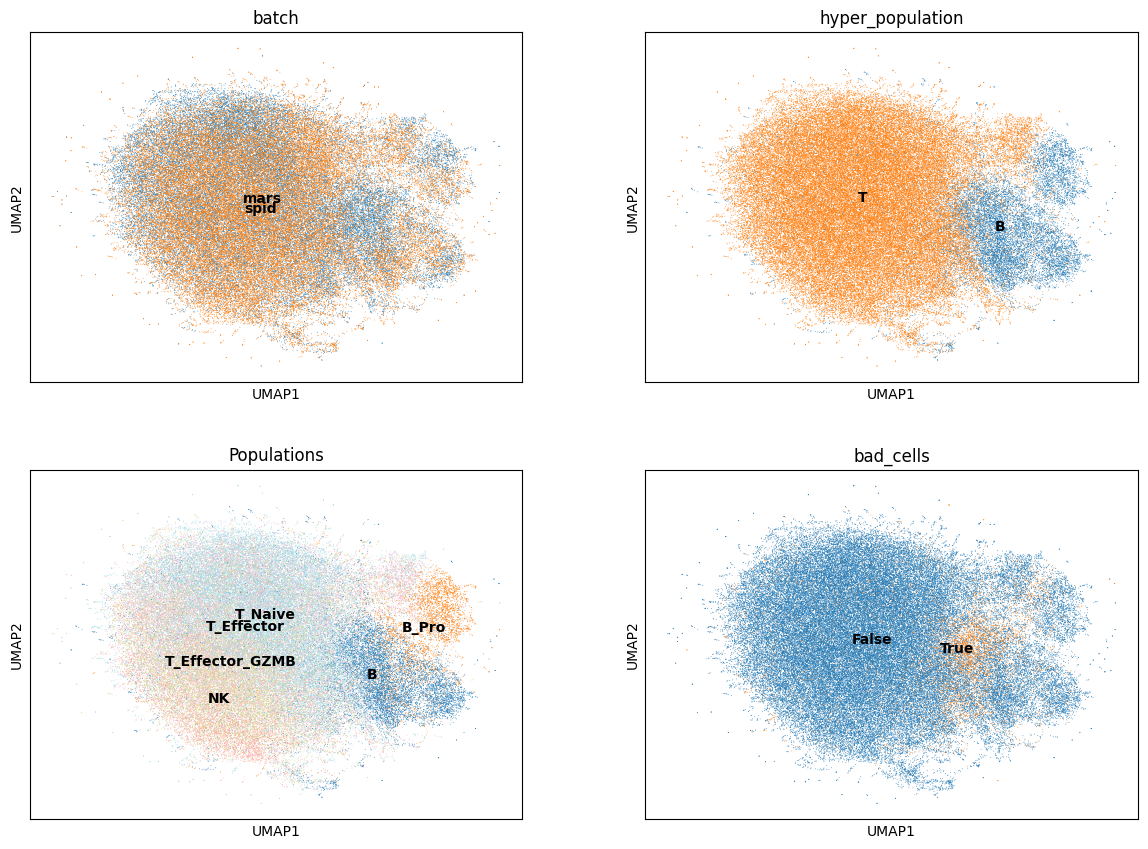

In [47]:
sc.pl.umap(adata_B_T, neighbors_key="new_neigbros_key", color=['batch', 'hyper_population', label_col, 'bad_cells'], ncols=2, legend_loc="on data")

# evaluation of gene expession

/home/labs/amit/noamsh/.conda/envs/CLL_2024/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


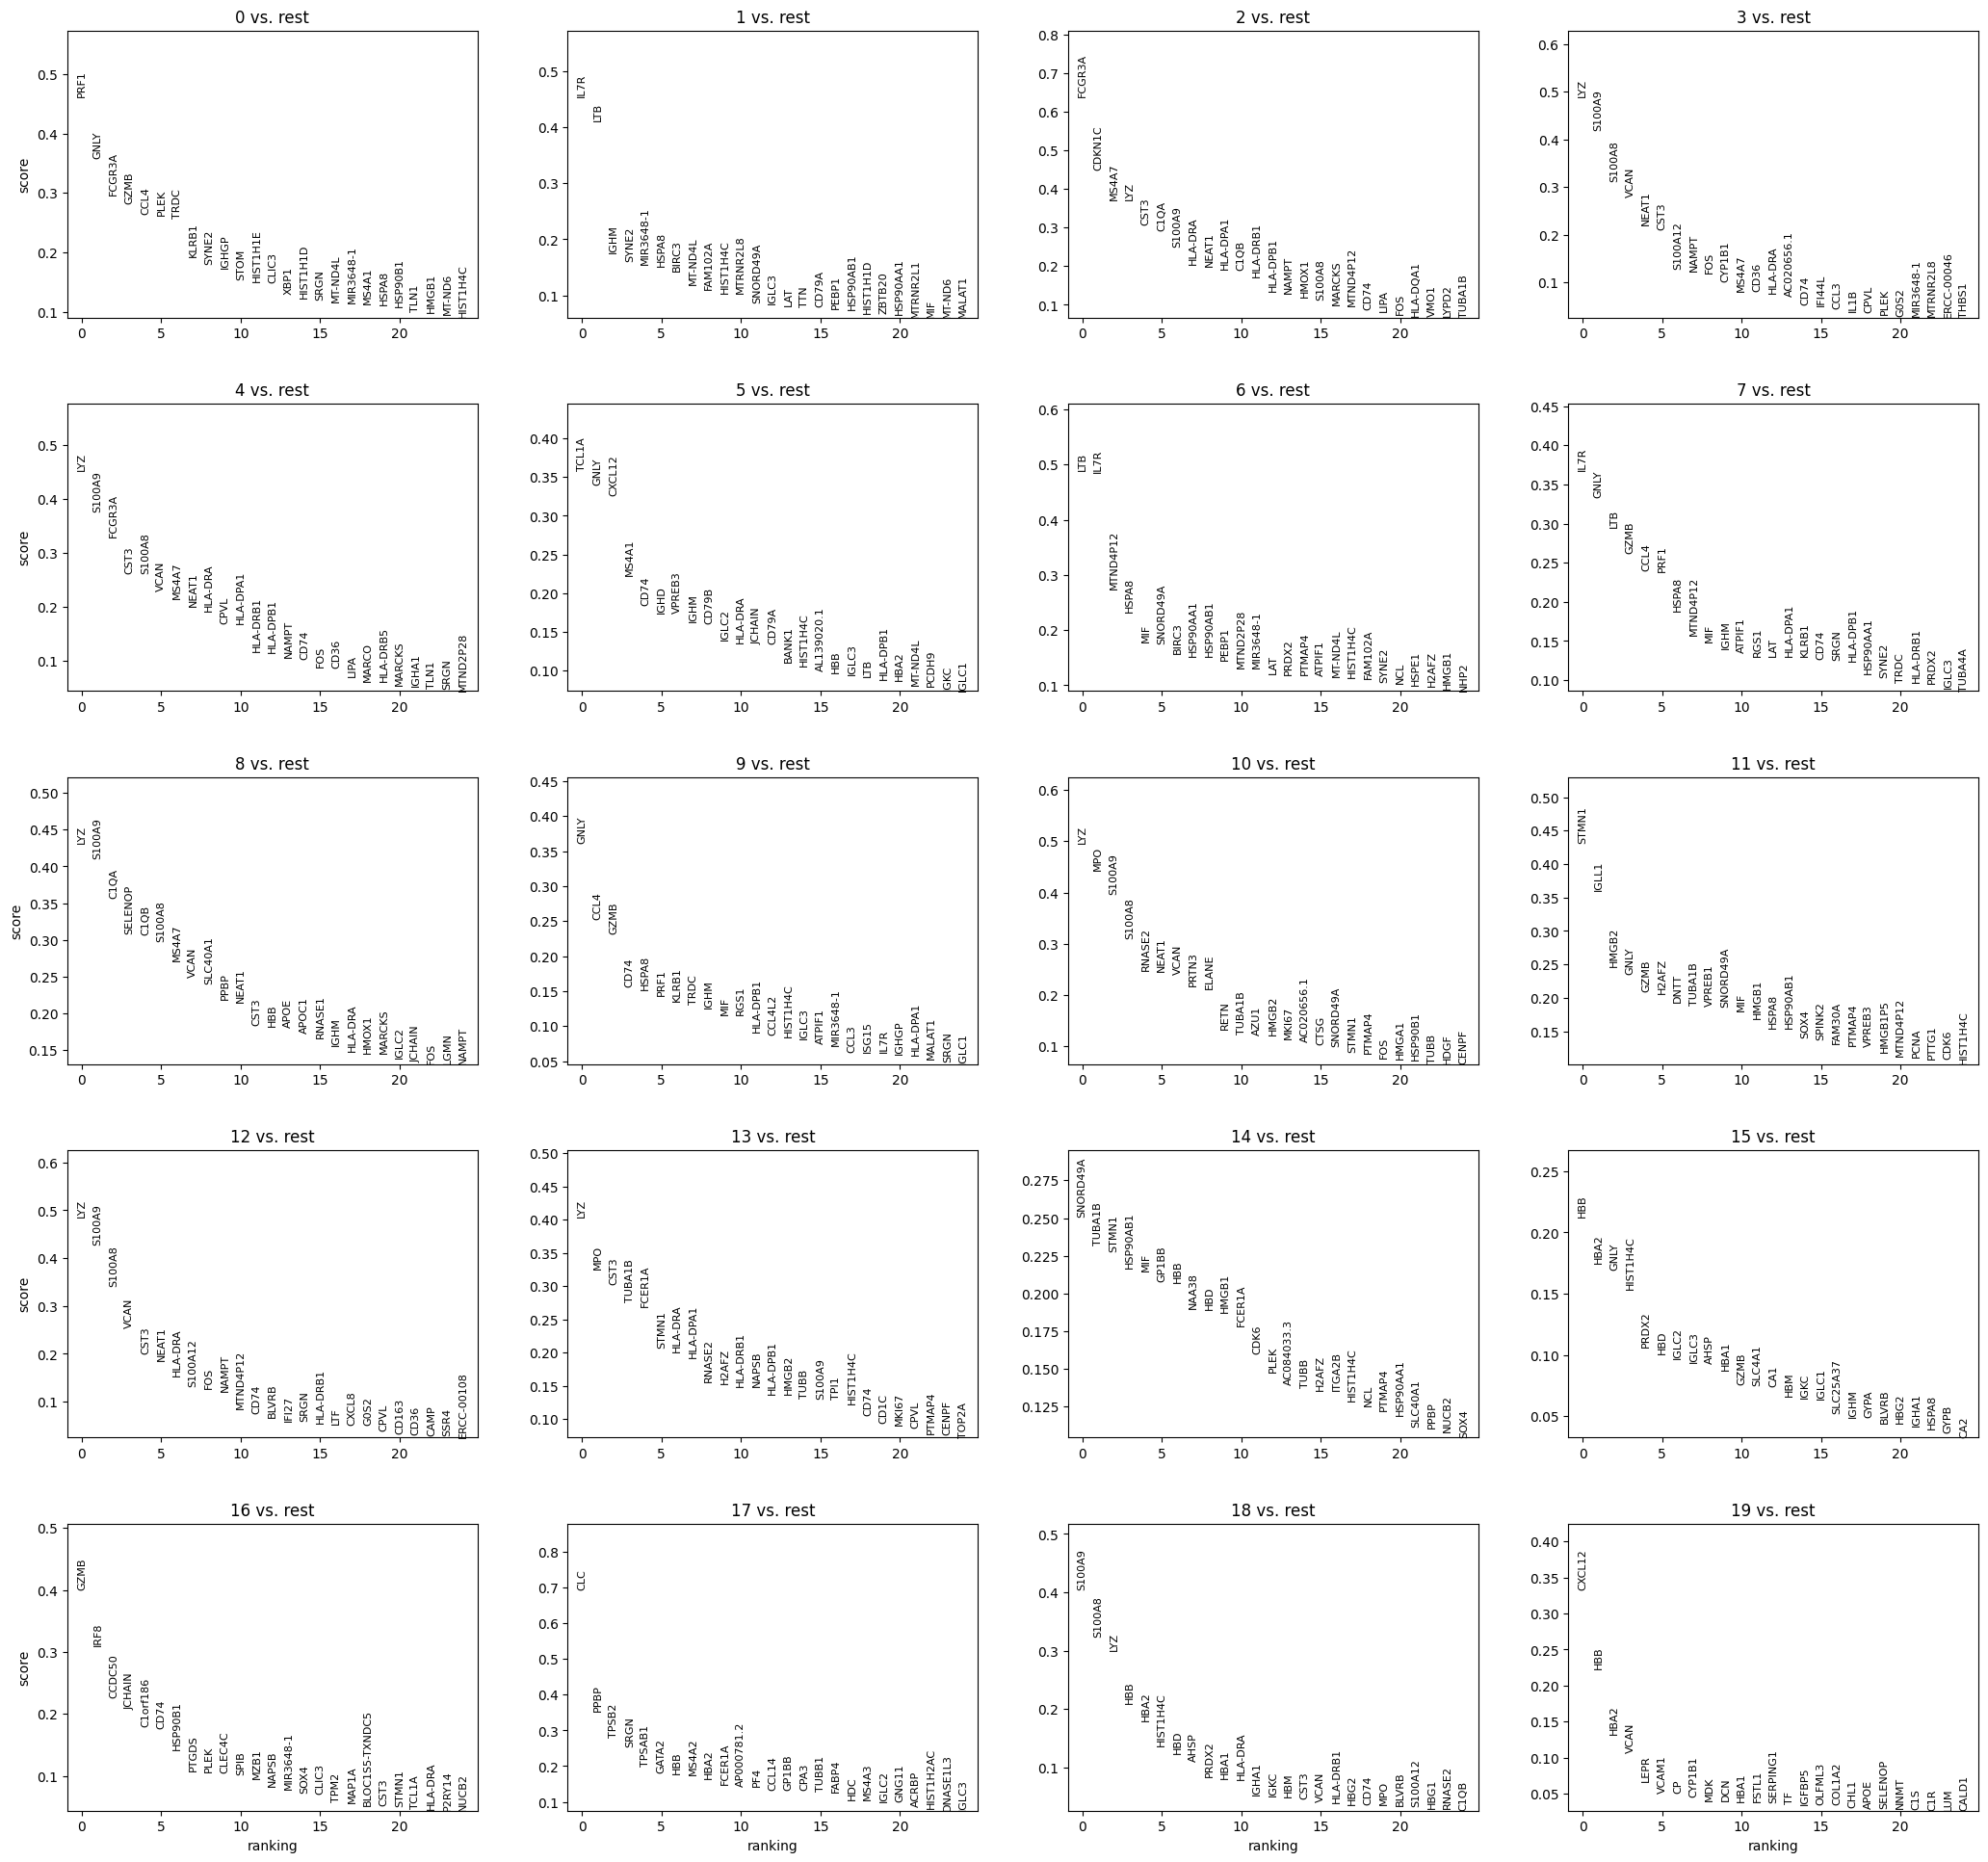

In [52]:
sc.tl.rank_genes_groups(adata, 'leiden', method='logreg')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

In [53]:
sum(adata.obs["bad_cells_spid"].astype(bool) | adata.obs["bad_cells_mars"].astype(bool))

8436

In [56]:
adata.obs[adata.obs["bad_cells_spid"].astype(bool) | adata.obs["bad_cells_mars"].astype(bool)]["Gating"].value_counts()

Gating
CD45           3327
PC             1979
CD19           1581
TCRb            455
PIC             431
CD45dim         207
CD34            189
PC+CD45         137
GPRC5D          110
TRCb             13
CD11B             6
CD138_CD11B       1
CD3               0
-                 0
CD3_CD11B         0
gdT               0
Name: count, dtype: int64